In [138]:
import re

import numpy as np
np.random.seed(42)
import torch


# Data extraction

In [36]:

text = '''Machine learning is the study of computer algorithms that 
improve automatically through experience. It is seen as a 
subset of artificial intelligence. Machine learning algorithms 
build a mathematical model based on sample data, known as 
training data, in order to make predictions or decisions without 
being explicitly programmed to do so. Machine learning algorithms 
are used in a wide variety of applications, such as email filtering 
and computer vision, where it is difficult or infeasible to develop 
conventional algorithms to perform the needed tasks.'''

In [90]:

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

def concat(*iterables):
    for iterable in iterables:
        yield from iterable
        
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue

            # X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            # y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
            X.append(word_to_id[tokens[i]])
            y.append(word_to_id[tokens[j]])
    
    return np.asarray(X), np.asarray(y)


In [155]:
tokens = tokenize(text)
word_to_id, id_to_word = mapping(tokens)
X, y = generate_training_data(tokens, word_to_id, window=2)
X=torch.tensor(X,dtype=torch.int32,requires_grad=False)
y=torch.tensor(y,dtype=torch.int32,requires_grad=False)
'''

Notation followed:

X -> Center word
y -> context word




'''


In [161]:
print(f"The shape of X is{X.shape}")
print(f"The shape of y is{y.shape}")
print(f"Few samples of X are {X[:20]}")
print(f"Few samples of X are{y[:20]}")

The shape of X istorch.Size([330, 1])
The shape of y istorch.Size([330])
Few samples of X are tensor([[25],
        [25],
        [27],
        [27],
        [27],
        [28],
        [28],
        [28],
        [28],
        [42],
        [42],
        [42],
        [42],
        [20],
        [20],
        [20],
        [20],
        [49],
        [49],
        [49]], dtype=torch.int32)
Few samples of X aretensor([27, 28, 25, 28, 42, 25, 27, 42, 20, 27, 28, 20, 49, 28, 42, 49,  1, 42,
        20,  1], dtype=torch.int32)


## Model building

In [158]:
import torch.nn as nn
import torch

EMBED_DIMENSION=3
EMBED_MAX_NORM=1
 


## Defining the model 

In [163]:
'''

CBOW -> Given the context  , predict the center word .
Skip Gram -> Given the center word , predict the the context.



'''


class CBOW_Model(nn.Module):
    """
    Implementation of CBOW model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )
    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x
    def __str__(self) -> str:
        return "CBOW_Model" 

class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):

        super(SkipGram_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )

        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = self.linear(x)
        return x
    def __str__(self) -> str:
        return "SkipGram_Model" 


## CBOW

### Initializing the model 

In [165]:
model=CBOW_Model(vocab_size=len(list(set(tokens))))
y=y.unsqueeze(1) # Formatting so that There wont be any issues with the dimensions
print(f"For the {model}")
print(f"Input vector shape {y.shape}")
print(f"Model output vector shape {model(y).shape}")

For the CBOW_Model
Input vector dimesiontorch.Size([330, 1])
Model output vector dimesiontorch.Size([330, 60])


### initalize the optimiser

In [ ]:
import torch.optim as optim


learning_rate = 0.001
# Create the Adam optimizer and pass in the model parameters and learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.CrossEntropyLoss()
running_loss=[]
num_of_epochs=2000


# SG_Model_0=SkipGram_Model(vocab_size=len(list(set(tokens))))
# print(f"For the {SG_Model_0}")
# print(f"Input vector dimesion{y.shape}")
# print(f"Model output vector dimesion{SG_Model_0(y).shape}")


## Training

In [132]:
model=CBOW_Model(vocab_size=len(list(set(tokens))))
import torch.optim as optim
learning_rate = 0.001
# Create the Adam optimizer and pass in the model parameters and learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.CrossEntropyLoss()
running_loss=[]
num_of_epochs=2000

In [133]:


for i in range(num_of_epochs):
    
    inputs = X
    labels = y

    # print(f"Input data shape:{inputs.shape}")
    # print(f"Output data shape:{labels.shape}")


    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels.long())
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())

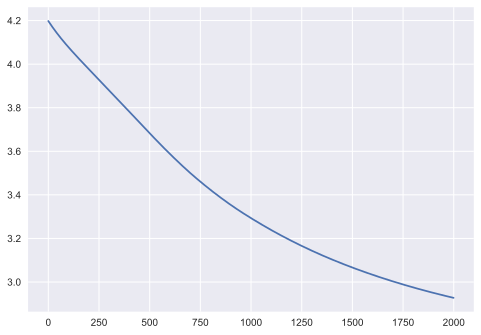

In [134]:
import matplotlib.pyplot as plt

plt.plot(running_loss)

In [151]:
List_of_words=["computer" ,"algorithms"]
Tensor_of_tokens=torch.tensor([word_to_id[x] for x in List_of_words])
model.embeddings.forward(Tensor_of_tokens)

tensor([[ 0.1561,  0.9656, -0.2080],
        [-0.4720, -0.0292,  0.4925]], grad_fn=<EmbeddingBackward0>)